In [59]:
#Import data cleaning library
import pandas as pd
import numpy as np

#Import Machine Learning Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import chi2

#Import the plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import math

import missingno as msno

from sklearn import metrics

#import pymice library from the research paper
from ampute import MultivariateAmputation

from mlxtend.frequent_patterns import apriori

In [60]:
#Read the Trips Data Set and explore the data
df_missing = pd.read_csv("TripsWithMissing.csv")
df_not_missing = pd.read_csv("TripsWithoutMissing.csv")

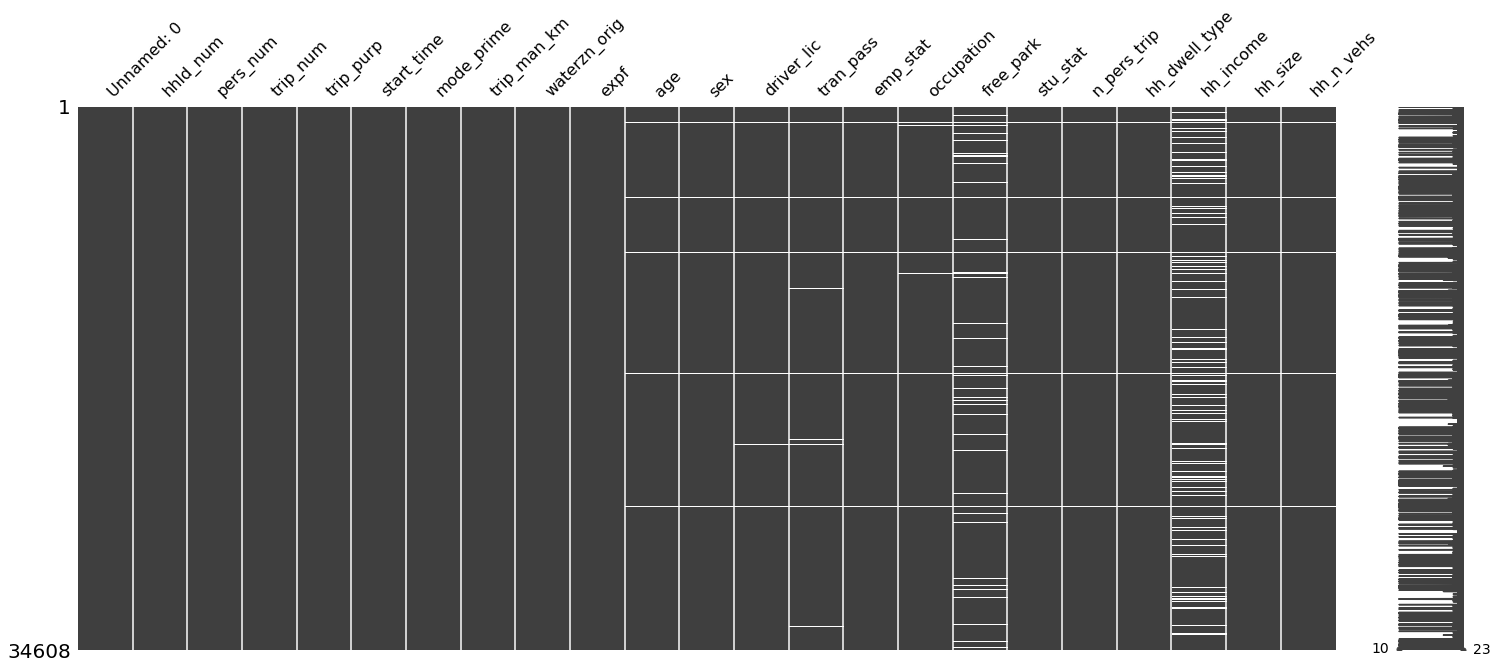

In [61]:
msno.matrix(df_missing.sample(34608))

In [62]:
def none_filling(df_none_filled, name=None):
    #create array of the feature names in the dataframes which contatin none values
    none_columns = []
    #fill the none values in the data frame with 'None_{feature_name}'
    for i in range(df_none_filled.shape[1]):
        if df_none_filled.columns[i] != name:
            none_columns.append("None_{}".format(df_none_filled.columns[i]))
        for j in range(df_none_filled.shape[0]):
            if df_none_filled.iat[j,i] is np.nan:
                df_none_filled.iat[j,i] = "None_{}".format(df_none_filled.columns[i])
    return none_columns

In [63]:
def cat_encoding(df_none_filled):
    df_to_encode = df_none_filled
    #dummy encode all the categorical variabels
    nominal_encoder = OneHotEncoder(sparse=False)
    # transform data
    #Iterate through the nominal feature dataframe
    for i in range(df_to_encode.shape[1]):
        #Encode the feature in the current iteration cycle 
        encode = nominal_encoder.fit_transform(df_to_encode.iloc[:, i].to_numpy().reshape(-1, 1))
        #Save the current feature column
        nominal_col = df_to_encode.iloc[:, i]
        #If first feature create a variable which will be added on when i != 0
        if i == 0:
            df_encoded = pd.DataFrame(data = encode, columns = [i for i in nominal_col.unique()[:]] )
        else:
            df_encoded_2 = pd.DataFrame(data = encode, columns = [i for i in nominal_col.unique()[:]] )
            #Merge the df in this iteration cycle with the one formed in the zeroeth cycle (and concacted in the subsequent cycles)
            df_encoded = pd.merge(df_encoded, df_encoded_2, how='inner', left_index=True, right_index = True)
    #Display the final encoded dataframe of the nominal dataframe
    return df_encoded

In [64]:
#finding coefficents
def find_coeff(df_encoded, isMissing):
    #X are the features to find coeff for
    X = df_encoded.astype(float)
    #Y is the feature which the coeff will be for
    y = isMissing.astype(float)
    #find the p-values for each of the features in the X dataframe
    scores, pvalues = chi2(X, y)
    X_drop  = X[:]
    #store the indicies of the features with p value of less than 0.05
    dr = np.array([])
    dr = np.append(dr, np.where(pvalues > 0.05))
    #remove the features with said p value threshold
    for i in dr:
        X_drop = X_drop.drop(X.columns[i], axis=1)
    #train the logestic regression model
    X_train, X_test, y_train, y_test = train_test_split(X_drop,y, test_size=0.3, random_state=0)
    logreg = LogisticRegression()
    #fit the model
    logreg.fit(X_train, y_train)
    #predict y 
    y_pred = logreg.predict(X_test)
    #show the predictive accuracy
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_pred)))
    
    #get the coefficents
    coeff = logreg.coef_[0]
    #insert 0.00 as the coeffecient values for the features dropped during training and testing due to their p values
    for k in dr:
        coeff = np.insert(coeff,int(k),0.0000)
    #return the coeff array
    return coeff

In [65]:
#list of the features which should not be included in the following dataframes
c = ['Unnamed: 0', 'hhld_num' ,'pers_num',  'trip_num', 'waterzn_orig', 'expf']

In [66]:
#df used to creating the encoded dataset to create the  dummy array
q = df_missing[[l for l in df_not_missing.columns if l not in c]]

#df used to create the enocoded dataset with no missing values (will be used as the df to ampute on).
u = df_not_missing[[l for l in df_not_missing.columns if l not in c]]

#df used for finding the indicies for missing values pertaining to each missing combinations
for_y = df_missing[[l for l in df_not_missing.columns if l not in c]]

In [67]:
#fill all the none values in q
none_filling(q)
#hot encode the q dataframe
test = cat_encoding(q)
#drop all the none values from the columnspace
test = test.drop(['None_age',
 'None_sex',
 'None_driver_lic',
 'None_tran_pass',
 'None_emp_stat',
 'None_occupation',
 'None_free_park',
 'None_stu_stat',
 'None_n_pers_trip',
 'None_hh_dwell_type',
 'None_hh_income',
 'None_hh_size',
 'None_hh_n_vehs'], axis = 1)

In [68]:
#create a dummy array which stores the columns indices of all the features in the encoded dataset
#catch here is all the values pertaining to one feature in the not encoded dataset is assigned a unique value
# for example: if the index of trans_pass is 2 in the not encoded dataset, then all the unique value of that feature (which becomes columns in the encoded df) are stored as 2
dummy_array = np.zeros(test.shape[1])
k = 0
for i in range(q.shape[1]):
    for j in range(len(u.iloc[:,i].unique())):
        dummy_array[k] = i
        k+=1

In [69]:
#store all the unique missing value combinations of a row in the missing dataset
pattern_1 = []
counter = 0
#go through each row
for i in range(for_y.shape[0]):
        #find the indexes where the values are missing in a row
        index = np.where(for_y.iloc[i,:].isnull())[0]
        #if the index list is not empty
        if len(index) != 0:
            #if it is the first entry in the pattern_1 list
            if len(pattern_1) == 0:
                #add it to the list
                pattern_1.append(list(index))
                print(index)
            else:
                #if this combination is not already in the pattern_1, store it in pattern_1
                if(list(index) not in pattern_1):
                    pattern_1.append(list(index))
                    print(index)
            counter+=1

[14]
[10]
[ 4  5  6  7  8  9 10 11 12 13 14 15 16]
[7]
[10 14]
[9]
[ 6  7 14]
[ 7 10]
[ 7 14]
[6]
[ 9 10]
[ 7  9 10 14]
[ 7  9 14]
[ 9 14]
[8]
[ 7 10 14]
[ 9 10 14]
[ 8 14]
[ 6 10]
[ 6 14]
[6 7]
[ 6 10 14]
[ 6  7 10 14]
[ 6  7 10]
[6 9]


In [70]:
#creating a pattern_matrix so it can be processed by the ampute class in the pymice library
pattern_matrix = np.array(np.zeros(test.shape[1]), ndmin = 2)
#for each missing combination in pattern_1 create an array of mostly zeroes and ones
#zeroes are allocated to the features that are not missing and ones are assigned to features that are missing
#NOTE: the pattern_matrix has the shape of the encoded dataframe so the dummy array is used for the mapping of missing combinations from the not encoded dataframe to the encoded dataframe
for i in pattern_1:
    pattern  = np.zeros(test.shape[1])
    for j in i:
        indicies_d = np.where(dummy_array == j)
        for k in indicies_d:
            pattern[k] = 1
    pattern_matrix = np.append(pattern_matrix, [pattern], axis = 0)

In [71]:
#delete first row of the pattern_matrix as it was just used to initialize the matrix
pattern_matrix = np.delete(pattern_matrix, 0, 0)

In [72]:
#Create a dataframe of all the different missing combination
#each column represent each missing combo
#the column contains missing values at indexes identical to the ones of missing value combination in the missing value dataset
Y_res = pd.DataFrame(data = np.ones(45208), columns = ['remove'])
#the freq array represents how frequent the missing combination occurs. all the values of the freq_array should sum to one
freq_array = np.zeros(8191)

In [73]:
count = 0
for l in pattern_1:
    #create a column for each missing combination
    y = pd.DataFrame(data = np.ones(45208), columns = [str(count)])
    add = 0
    #go through each row of the missing dataset
    for i in range(for_y.shape[0]):
        #assign 0 values to the y column at the indexes where the missing combo occurs
        index = np.where(for_y.iloc[i,:].isnull())[0]
        index.sort()
        l.sort()
        if len(index) == len(l):
            if np.array_equal(l, index):
                add+=1
                y.iat[i,0] = 0
                #add one to the freq array for each time a value goes 'missing' in the y column
                freq_array[count]+=1
    #if the y column has missing values
    if add != 0:
        #add the y column to the Y_res dataframe
        Y_res = Y_res.join(y)
        print(count)
        count+=1                

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [74]:
#remove the initial column used to initalize the Y_res dataframe
Y_res = Y_res.drop(['remove'],axis=1)
#divide each element in the freq array by 10600.0 (total number of rows with missing values)
freq_array = freq_array/10600.0

In [19]:
#read the Y_res and freq_arr files
Y_res = pd.read_feather('Y_res')
freq_arr = np.load('freq_array_update.npy')

In [52]:
#create the coefficent matrix for all the differnt missing combinations
#each missing combination has its own unique coeffecient array/row in the matrix
count = 0
coeff_matrix = np.array(np.zeros(test.shape[1]), ndmin = 2)
for i in Y_res.columns:
    X = pd.DataFrame(test[:])
    indicies = np.array([])
    for j in pattern_1[count]:
        #get all the indicies where the current y column is in the encoded dataframe
        indicies = np.append(indicies, np.where(dummy_array == j))
    #find the columns of from the indicies
    columns = np.array([test.columns[x] for x in indicies])
    #drop the columns from X
    X = X.drop(columns, axis=1)
    #find the coeff
    coeff = find_coeff(X, Y_res[[i]])
    #insert 0 in the coeff matrix at the indcies where the y feature will be present
    for p in indicies:
        coeff = np.insert(coeff, int(p), 0)
    #add the coeff row to the coeff matrix
    coeff_matrix = np.append(coeff_matrix, [coeff], axis=0)
    count+=1

14
[58. 59. 60. 61. 62. 63.]
['40k-59k' '>124k' '100k-124k' '60k-99k' '15k-39k' '<15k']
[8.68828546e-004 5.08725368e-001 6.09291872e-006 2.87618659e-003
 1.47662963e-002 1.24744069e-008 7.04581623e-002 5.51571534e-005
 6.28528806e-005 4.01456898e-001 7.72540319e-001 3.77600403e-001
 3.41254202e-001 1.14931661e-001 7.44373559e-001 6.39705566e-001
 2.30139071e-001 2.24949873e-001 9.77222806e-002 5.31997094e-001
 4.12177962e-001 5.42310226e-007 7.68536341e-008 5.15316139e-036
 5.99768463e-012 6.55888418e-004 3.44847687e-001 2.28940717e-002
 5.19193331e-007 1.73141312e-031 3.35955421e-020 3.52404917e-005
 3.09201524e-003 4.55525764e-007 5.16711149e-025 1.80400785e-001
 2.51558194e-028 1.08216649e-005 4.84403703e-024 8.04943822e-021
 4.70894410e-024 1.13195851e-027 2.64923861e-001 8.88105162e-026
 1.78858726e-068 2.78752259e-008 7.05219218e-137 1.78858726e-068
 3.35955421e-020 7.21741380e-001 4.75642796e-013 4.05277390e-001
 1.96556866e-006 2.24417675e-002 4.66710050e-006 4.99638481e-006
 6

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of logistic regression classifier on test set: 0.85
44
[ 0.02659635  0.          0.01880923  0.23568457  0.26031277  0.64508626
  0.         -0.15988341  0.03102958  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.23310114  0.42755325  0.71334826
  0.30391269  0.14346948  0.          0.0178975  -0.04100678 -0.08388281
  0.21133178  0.09636629  0.18829927  0.06852789  2.00457708  0.
  2.16655    -0.68454044  0.19058729  0.94553951  0.14908488  0.05876681
  0.          1.90027332 -0.0550066   0.14754889  4.30496508 -0.0550066
  0.21133178  0.         -0.21964097  0.          0.0880575  -0.14318394
  0.12296942 -0.0828907  -0.35459198  0.21133178  0.13738101  0.
  0.          0.          0.21133178  0.          0.3265222   0.36203634
  0.21133178]
67
10
[45. 46. 47.]
['Y' 'Not Applicable' 'N']
[3.49122577e-004 2.25944293e-005 8.08675726e-001 3.00701396e-002
 7.60160980e-002 4.73394831e-001 4.37344

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_s

Accuracy of logistic regression classifier on test set: 0.95
47
[-0.20601698  0.24067765  0.         -0.13003628  0.          0.
  0.3294108   0.18453417  0.44866364  0.          0.          0.
  0.          0.         -0.26549122  0.          0.          0.
  0.          0.          0.          0.76846329 -0.11804577  0.20147974
  0.50973419  0.35130822  0.36549085  0.1862315  -0.12905977  0.09536187
 -0.05890711  0.17388705 -0.09312865 -0.47971311  1.04238243  0.
  1.87691579 -0.9627119  -0.78430309 -0.05536025 -3.74867128  0.19549045
 -0.72641334  1.69842999  4.61373277 -0.05890711  0.18894242  0.09584791
  0.24125869  0.          0.         -0.2992258   0.          0.
 -0.05890711  0.00903368 -0.09665218  0.08676956  0.          0.28250521
  4.79380737  0.128079    0.         -0.0672818  -0.17123923 -0.05890711
  0.         -0.18922232  0.         -0.05890711]
70
4
5
6
7
8
9
10
11
12
13
14
15
16
[21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 4

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
24
[ 0.25594062 -0.0864607  -0.16939652  0.          0.          0.
  0.         -0.8659745   0.          0.          0.          0.68066508
  0.          0.          0.          0.          0.         -0.58480015
  0.          0.         -0.82174768 -0.96297344 -0.74997096  1.39264192
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.15260643  0.         -0.71909133
  0.          0.44423613  0.          0.          0.          0.
  0.          1.4040985   0.          0.          0.         -0.65610898
  0.          0.          0.30394735  1.6006331  -0.22300956  0.
  0.          0.          0.         -0.20702012  0.          0.84359182
  2.08595785  0.          0.          0.          0.27837912  0.
  0.         -0.53373442  0.39912932  0.        ]
70
10
14
[45. 46. 47. 58. 59. 60. 61. 62. 63.]
['Y' 'Not Applicable' 'N' '40k-59k' '>124k' '100k-124k' '60k-99k'
 '15k-39k'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 0.99
27
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.21355856  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.36090222  0.19673558  0.         -0.21385513
 -0.32453573  0.25850565 -0.24743008  0.          0.         -0.55452451
  0.13557313  0.          0.         -0.33770079  0.57137933  0.
  0.90594324  0.         -0.71471696  0.13811454 -2.72505588  0.04493754
 -0.49843388  0.94431498  3.30115384  0.13557313  0.6021956   0.
  0.          0.          0.51394639 -0.36887579  0.          0.
  0.13557313  0.          0.          0.          0.          0.13557313
  0.          0.12441613  0.          0.13557313]
64
9
[41. 42. 43. 44.]
['Retail&Service' 'Not_employed_y' 'General_Office' 'Manufacturing']
[3.44545597e-04 2.08452284e-05 7.92885800e-01 8.35683457e-03
 3.09900412e-02 7.82869925e-04 4.64944777e-01 1.081

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
25
[ 0.35449718 -0.46098684  0.         -0.08409374  0.0822798  -0.72736969
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.77884702
  0.          0.         -0.74556864  0.17225965  0.         -0.93105233
 -1.20707175  0.          0.          0.          0.38035616 -0.16122086
  0.          0.          0.          0.          0.          0.
  0.          0.         -1.54030787  0.          0.26264851 -0.8036875
  1.25684732  1.27168228  0.          0.          0.         -0.95377274
 -0.76822726  0.50465602  1.48462879  0.          0.          0.
  0.          0.         -0.2803396   0.          0.          1.68444681
 -0.68717254  0.19255118  0.          0.          0.          0.
  0.          0.          0.        ]
69
6
7
14
[33. 34. 35. 36. 37. 58. 59. 60. 61. 62. 63.]
['Y_x' 'N_x' 'N_y' 'Other_agency' 'Y_y' '40k-59k' '>124k' '100k-124k'
 '

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
12
[ 0.          0.          0.          0.          0.          0.
  0.98247258  0.          0.         -0.3539782  -0.82295471  0.
 -1.32266377  0.          0.          0.          0.          0.
  0.          0.          0.         -0.6062211  -1.51747759  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.7000155   0.          0.
  0.          0.          0.         -0.75909164  0.          0.
 -0.75909164  0.          0.         -1.38483495  0.          0.
  0.          0.         -0.45075693  0.          0.          0.
  0.          0.          0.          0.         -0.86841058  0.
  0.          0.        ]
62
7
10
[35. 36. 37. 45. 46. 47.]
['N_y' 'Other_agency' 'Y_y' 'Y' 'Not Applicable' 'N']
[1.41918248e-02 1.13638845e-04 1.22613034e-01 3.98047842e-01
 4.89398266e-01 8.72246920e-03 4.28462461e-01 4.42783587e-01
 4.10468287e-01 3.27235060e-01 1.40179258e-01 6.76

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
17
[ 0.43779141 -0.54687274  0.          0.          0.         -0.34440962
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -1.48631019  0.         -1.47659291  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -1.6391922   0.         -0.20021355  0.          1.46280249
  0.          0.         -1.05338467  0.          0.98655966  0.73013883
  0.          0.          0.          0.          0.          0.
 -1.14383383 -1.31474143  0.          0.8906174   0.          0.
 -1.55347305  0.          0.         -0.53605648  0.          1.10120944
  0.        ]
67
7
14
[35. 36. 37. 58. 59. 60. 61. 62. 63.]
['N_y' 'Other_agency' 'Y_y' '40k-59k' '>124k' '100k-124k' '60k-99k'
 '15k-39k' '<15k']
[8.62219890e-01 2.01506744e-01 3.30306292e

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
8
[ 0.          0.          1.14940882  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.69101107  1.01629373
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -1.24172104  0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.53559694  1.25818823  1.03077887  0.          0.
  0.          0.          0.          1.45154025  0.          0.
  0.          0.          0.          0.        ]
64
6
[33. 34.]
['Y_x' 'N_x']
[6.16306280e-05 1.16244656e-10 6.46810816e-03 3.57741687e-01
 4.51896925e-01 3.13018062e-01 1.08045770e-11 5.22894716e-02
 2.16841964e-01 4.39238622e-22 2.07161908e-42 6.79067519e-07
 2.11051140e-01 1

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
31
[ 0.30594412 -0.37516938  0.06936595  0.          0.          0.
  2.32675562  0.          0.         -0.00665873 -0.73090981 -0.25127357
  0.          0.          0.          0.          0.          0.
  0.          1.23707408  0.          0.53314058  0.02742186  0.
  0.          0.          0.85773407  0.74974884  1.00812613  0.
  0.          0.          0.          1.85020888  0.          0.05117734
  0.          0.          0.          0.          0.          0.
 -0.07033442 -0.77416577  1.02847357 -0.07033442  0.          0.39451976
 -1.24052533  0.          0.14635794  0.17954926  0.6295212   0.48050516
  0.          0.         -1.26797095  0.          0.55770106 -0.46074276
  0.          1.6236376   0.          0.          0.          0.
  0.         -0.83311916  0.         -0.20506608  0.        ]
71
9
10
[41. 42. 43. 44. 45. 46. 47.]
['Retail&Service' 'Not_employed_y' 'General_Office' 'Manufacturing' 'Y'
 'Not App

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
9
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -1.14959969  0.
  0.          0.          0.          0.          0.         -1.22884785
 -0.4171904   0.          0.         -1.24139265  0.          0.
  0.          0.          0.97770655  0.          0.          0.
  0.          0.          0.          0.         -1.69090171  0.
  0.          0.         -1.41583808  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -1.89050339  0.          0.          0.          0.
 -0.59371205  0.          0.          0.          0.          0.        ]
66
7
9
10
14
[35. 36. 37. 41. 42. 43. 44. 45. 46. 47. 58. 59. 60. 61. 62. 63.]
['N_y' 'Other_agency' 'Y_y' 'Retail&Service' 'Not_employed_y'
 'General_Office' 'Manufacturing' 'Y' 'Not Applicable' 'N' '40k-

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
4
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -1.24338016  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -1.69099551  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -1.79487934
  0.          0.          0.          0.          0.          0.
  0.          0.         -1.44037142  0.          0.          0.
  0.          0.          0.        ]
57
7
9
14
[35. 36. 37. 41. 42. 43. 44. 58. 59. 60. 61. 62. 63.]
['N_y' 'Other_agency' 'Y_y' 'Retail&Service' 'Not_employed_y'
 'General_Office' 'Manufacturing' '40k-59k' '>124k' '100k-124k' '60k-99k'
 '15k-39k' '<15k']
[7.34767490e-01 9.37604949e-01 5.02523472e-01 2.72791759e-01
 3.69709398e-01 8.27204821

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
5
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.59353319  0.          0.          0.          0.
  0.         -1.38388057  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -1.36193209  0.          0.          0.
  0.          0.         -1.36400291  0.          0.          0.
  0.          0.          0.          0.          0.         -1.16755322
  0.          0.          0.          0.          0.          0.        ]
60
9
14
[41. 42. 43. 44. 58. 59. 60. 61. 62. 63.]
['Retail&Service' 'Not_employed_y' 'General_Office' 'Manufacturing'
 '40k-59k' '>124k' '100k-124k' '60k-99k' '15k-39k' '<15k']
[4.43781277e-01 1.57923190e-01 4.34725273e-01 1.55877146e-01
 2.45746530e-01 5.72942746e-01 6

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
6
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -1.34083845
 -1.20756448  0.          0.          0.          0.          0.
  0.          0.         -1.02290509  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.45963639  0.          0.          0.          0.
 -0.96445554  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.8396163   0.        ]
63
8
[38. 39. 40.]
['Employed' 'Not_employed_x' 'Work_at_Home']
[4.54177623e-02 3.03842159e-02 8.71105561e-01 9.69191855e-02
 1.74530375e-01 6.49503018e-01 9.04691978e-01 5.72211960e-01
 9.29255520e-01 4.70939859e-01 1.25880317e-01 1.7833744

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
8
[-1.0110789   0.38165924  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.44900712  0.          0.         -0.80996949
  0.          0.         -0.80996949  0.          0.          0.
  0.          0.          0.          0.         -0.37954359  0.
  0.          0.          0.          0.          0.          0.
  0.         -0.79994594  0.          0.          0.          0.
  0.         -1.44021645  0.          0.        ]
70
7
10
14
[35. 36. 37. 45. 46. 47. 58. 59. 60. 61. 62. 63.]
['N_y' 'Other_agency' 'Y_y' 'Y' 'Not Applicable' 'N' '40k-59k' '>124k'
 '100k-124k' '60k-99k' '15k-39k'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
5
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -1.38812911  0.          0.          0.
  0.          0.          0.         -1.02117102  0.          0.
  0.          0.          0.          0.         -1.56380201  0.
  0.          0.          0.          0.18270677  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -1.28892485  0.          0.
  0.        ]
61
9
10
14
[41. 42. 43. 44. 45. 46. 47. 58. 59. 60. 61. 62. 63.]
['Retail&Service' 'Not_employed_y' 'General_Office' 'Manufacturing' 'Y'
 'Not Applicable' 'N' '40k-59k' '>124k' '100k-124k' '60k-99k' '15k-39k'
 '<15k']
[1.71686739e-01 3.31313061e-02 4.06094863e-01 2.0539732

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
5
[ 0.         -1.06730474  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -1.74711131  0.          0.          0.          0.
 -0.61800092  0.          0.          0.          0.         -1.45963493
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.96890119  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
60
8
14
[38. 39. 40. 58. 59. 60. 61. 62. 63.]
['Employed' 'Not_employed_x' 'Work_at_Home' '40k-59k' '>124k' '100k-124k'
 '60k-99k' '15k-39k' '<15k']
[0.92304961 0.64205428 0.40609486 0.75413496 0.79781378 0.80099475
 0.51014561 0.75408183 0.44709656 0.68925104 0.6401357

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
7
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -1.08109067  0.          0.
  0.          0.         -1.2250186   0.         -1.20982998  0.
  0.          0.          0.          0.          0.         -0.83429887
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.85282834
  0.          0.         -0.85282834  0.          0.         -1.28009214
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
64
6
10
[33. 34. 45. 46. 47.]
['Y_x' 'N_x' 'Y' 'Not Applicable' 'N']
[9.41260279e-02 9.07110765e-03 3.08904845e-01 3.64878295e-01
 4.58597492e-01 7.57537635e-01 3.75889675e-02 7.01219953e-01
 2.23598488e-01 1.6066

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
8
[ 0.         -0.87826869  0.          0.          0.          0.
  1.02302479  0.          0.         -1.23142167  0.          0.
  0.          0.          0.          0.          0.          0.
 -0.47193605  0.          0.          0.         -1.1931035   0.
  0.          0.          0.         -0.66948011  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.92083855  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.75055854  0.
  0.          0.        ]
68
6
14
[33. 34. 58. 59. 60. 61. 62. 63.]
['Y_x' 'N_x' '40k-59k' '>124k' '100k-124k' '60k-99k' '15k-39k' '<15k']
[3.78010904e-02 3.23525473e-04 7.50428694e-02 9.52454057e-01
 9.61101826e-01 1.2206

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
20
[ 0.20755753 -0.36956629  0.          0.          0.         -0.8443708
  2.28885864  0.         -0.76768945 -0.33486869 -0.3336303  -0.42319167
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.60640823 -1.01987927  0.
  0.          0.          0.          0.          0.74062092  0.
  0.          0.          0.          0.          0.          0.29922613
  0.          0.          0.          0.          0.          0.
 -0.22673077  0.          0.         -0.22673077  0.          0.23005803
 -0.5006536   0.          0.          1.0694973   0.779314   -0.77780943
  0.          0.          0.          0.          0.          0.
  0.         -0.12786697  0.          0.          0.        ]
65
6
7
[33. 34. 35. 36. 37.]
['Y_x' 'N_x' 'N_y' 'Other_agency' 'Y_y']
[1.71686739e-01 3.31313061e-02 4.06094863e-01 6.33671340e-01
 6.96676701e-01 8.00994753e-01 8.95623110e-02 1.265308

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
10
[ 0.         -0.4030085   0.          0.          0.          0.
  0.         -0.86678241  0.          0.04328709  0.          0.
  0.         -0.81413178  0.          0.          0.          0.
  0.          0.          0.08009363 -0.7114009   0.          0.08598263
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.46006508  0.          0.
  0.          0.          0.          0.          0.         -0.75324583
  0.09778707  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
68
6
10
14
[33. 34. 45. 46. 47. 58. 59. 60. 61. 62. 63.]
['Y_x' 'N_x' 'Y' 'Not Applicable' 'N' '40k-59k' '>124k' '100k-124k'
 '60k-99k' '15k-39k' '<15k']
[9.23049608e-01 6.4205428

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
7
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -1.97777954  0.          0.          0.
  0.         -1.14965331  0.          0.          0.          0.
  0.         -1.02462559  0.          0.          0.         -0.98675106
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -1.49028834  0.         -1.06250944  0.
  0.          0.          0.         -1.31860352  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
62
6
7
10
14
[33. 34. 35. 36. 37. 45. 46. 47. 58. 59. 60. 61. 62. 63.]
['Y_x' 'N_x' 'N_y' 'Other_agency' 'Y_y' 'Y' 'Not Applicable' 'N' '40k-59k'
 '>124k' '100k-124k' '60k-99k' '15k-39k' '<15k']
[3.33816544e-01 1.31951815e-01 5.56907561e-01 8.24738070e-

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
4
[ 0.          0.          0.          0.          0.         -1.7914398
  0.          0.          0.          0.          0.         -1.23415122
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -1.34643074
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -1.44368812  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]
59
6
7
10
[33. 34. 35. 36. 37. 45. 46. 47.]
['Y_x' 'N_x' 'N_y' 'Other_agency' 'Y_y' 'Y' 'Not Applicable' 'N']
[1.71686739e-01 3.31313061e-02 4.06094863e-01 2.05397329e-01
 3.00296187e-01 1.55085973e-14 8.95623110e-02 7.54081826e-01
 4.47096561e-01 4.18100621e-06 6.40

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 1.00
9
[ 0.         -0.74566362  0.          0.          0.         -1.60182612
  0.          0.          0.         -0.49046865  0.          0.
  0.          0.          0.          0.          0.          0.
 -0.61665102  0.          0.          0.         -0.98081456  0.
  0.          0.         -0.5605408   0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -1.01921309  0.          0.          0.          0.          0.
 -0.93606064  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -1.26214292  0.          0.          0.        ]
65
6
9
[33. 34. 41. 42. 43. 44.]
['Y_x' 'N_x' 'Retail&Service' 'Not_employed_y' 'General_Office'
 'Manufacturing']
[3.33816544e-01 1.31951815e-01 5.56907561e-01 3.70570072e-01
 4.63922081e-01 8.58542875e-01 2.29969883

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [75]:
#check if all the elements in the freq_array sums to 1
sum_I=0
for i in freq_array:
    sum_I+=i
sum_I

1.0000000000000004

In [245]:
#df of the dataset with no missingdata
#this df is going to be used in the ampute class to create the amputed dataset of different proportions
to_ampute = cat_encoding(u)

In [53]:
#save the Y_res, freq_array, coeff_matrix, pattern_matrix, and to_ampute df for later use
#save the Y_res and to_ampute as feather
Y_res.to_feather('Y_res')
to_ampute.to_feather('To_Ampute')
#save the rest as .npy
np.save('freq_array_update.npy',arr=freq_array)
np.save('coeff_matrix_all.npy',arr=coeff_matrix)
np.save('pattern_matrix.npy',arr=pattern_matrix)